# Prepare patches

> Methods to prepare patches of input image

In [ ]:
#| default_exp patch

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
from torch import nn
import torch.functional as F
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

import yaml
from PIL import Image
from fastcore.basics import Path

/Users/gg/.local/share/virtualenvs/vit-pytorch-u3xJdwPd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# | export
CONFIG_PATH = '../config.yml'
DATA_PATH = Path('../input') 

(#3) [Path('../input/cat.jpeg'),Path('../input/cifar-10-batches-py'),Path('../input/cifar-10-python.tar.gz')]

Load parameters from the config file. 

In [ ]:
config = yaml.safe_load(open(CONFIG_PATH))

In [ ]:
dset = datasets.CIFAR10(DATA_PATH, download=True, train=True)

Files already downloaded and verified


In [ ]:
images, targets = dset.data, dset.targets
len(images), len(targets)

(50000, 50000)

Prepare a small batch of images to test the image processing.

In [ ]:
images.shape

(50000, 32, 32, 3)

Sample a bunch of points and select those as indices of the image for training.

In [ ]:
image_idx = np.random.randint(low=0, high=len(images), size=3)

In [ ]:
# corresponding labels
targets = [targets[t] for t in image_idx]
targets

[2, 7, 6]

What are the classes we are dealing with?

In [ ]:
#| export
from fastcore.xtras import dict2obj
from fastcore.basics import filter_dict, filter_values, val2idx

In [ ]:
# dict2obj lets you dotify dicts or nested dicts
clsidx = dict2obj(dset.class_to_idx)
clsidx.bird 

2

In [ ]:
# filter the dict based on a function that checks k and v
filter_dict(clsidx, lambda k,v: v in targets)

{'bird': 2, 'frog': 6, 'horse': 7}

In [ ]:
# filters based on just the values
filter_values(clsidx, lambda v: v in targets)

{'bird': 2, 'frog': 6, 'horse': 7}

In [ ]:
targets[0]

2

In [ ]:
clsidx

```json
{ 'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9}
```

In [ ]:
in_ch = config["patch"]["in_ch"]
out_ch = config["patch"]["out_ch"]

In [ ]:
# size of each small patch
patch_size = config['patch']['size']
patch_size

16

In [ ]:
images.shape[1:]

(32, 32, 3)

In [ ]:
images = torch.Tensor(images[image_idx])
images = images/255.
images.shape

torch.Size([3, 32, 32, 3])

Increase image size to match with ViT paper $224\times 224$

In [ ]:
#| export
import torchvision.transforms as T

In [ ]:
augs = T.Resize((224, 224))

In [ ]:
images = augs(images.permute(0, 3, 1, 2))
images.shape

torch.Size([3, 3, 224, 224])

In [ ]:
n_channels, height, width = images.shape[1:]
print(f"image height: {height}, width: {width}, channels: {n_channels}")
assert height==width

image height: 224, width: 224, channels: 3


In [ ]:
n_patches = (height*width)/(patch_size**2)  # is also sequence length to transformer
print(f"number of {patch_size}x{patch_size} patches in an image of shape {images.shape[1:]}: {n_patches}")

number of 16x16 patches in an image of shape torch.Size([3, 224, 224]): 196.0


In [ ]:
shape_patch = (n_patches, (patch_size**2)*in_ch)
print(f"shape of flattened 2D patches: {shape_patch}")

shape of flattened 2D patches: (196.0, 768)


In [ ]:
seq_len, embed_dim = (n_patches, (patch_size**2)*in_ch)
print(f"shape of embed dim (D): {embed_dim}")
print(f"shape of sequence length (N): {seq_len}")

shape of embed dim (D): 768
shape of sequence length (N): 196.0


Display a sample image with title.

In [ ]:
idx=2

Text(0.5, 1.0, "{'frog': 6}")

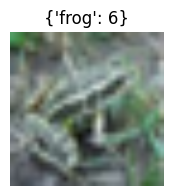

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(images[idx].permute(1, 2, 0))
plt.axis('off')
label = filter_values(clsidx, lambda v: v is targets[idx])
plt.title(label=label)

Use a convolutional layer to prepare a patched image.

In [ ]:
conv2d = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=patch_size, stride=patch_size)

PyTorch requires images in BCHW format.

In [ ]:
images.shape

torch.Size([3, 3, 224, 224])

In [ ]:
patched_image = conv2d(images)
patched_image.shape

torch.Size([3, 768, 14, 14])

In [ ]:
patched_image = patched_image.flatten(start_dim=2, end_dim=-1)
patched_image.shape # flatten to 1D

torch.Size([3, 768, 196])

In [ ]:
bs, _, _ = patched_image.shape

In [ ]:
class_token = nn.Parameter(torch.ones(bs, embed_dim, 1), requires_grad=True)
patched_image = torch.concat([class_token, patched_image], dim=-1)
patched_image.shape

torch.Size([3, 768, 197])

Add positional embedding for each patch. This doesnt change with batch or the single image.

In [ ]:
# +1 for the extra class token added above
pos_token = nn.Parameter(torch.ones(1, embed_dim, int(n_patches)+1), requires_grad=True)
pos_token.shape

torch.Size([1, 768, 197])

In [ ]:
patched_image += pos_token

PyTorch module that does all of the above.

In [ ]:
#| export

class PatchEmbedding(nn.Module):
    def __init__(self, channel_first=True) -> None:
        super().__init__()
        # patch related
        patch_size = config["patch"]["size"]
        in_ch = config["patch"]["in_ch"]
        out_ch = config["patch"]["out_ch"]
        n_patches = config["patch"]["n"]
        # data related
        bs = config["data"]["bs"]
        
        self.conv2d = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=patch_size,
            stride=patch_size,
        )
        self.channel_first = channel_first
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)
        # for all patches in the image prepend the class token
        ones_token = torch.ones(bs, 1, out_ch) # bs, 1, embed_dim
        self.class_token = nn.Parameter(ones_token, requires_grad=True)
        # for all images in the batch what is the order of patches
        ones_embed = torch.ones(1, n_patches+1, out_ch) # 1, n_patches+1, embed_dim
        self.pos_embed = nn.Parameter(ones_embed, requires_grad=True)

    def forward(self, x):
        if not self.channel_first:
            x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = self.conv2d(x)
        # print(x.shape)
        x = self.flatten(x) 
        x = x.permute(0, 2, 1) # (bs, patch_dim, embed_dim)
        x = torch.concat([self.class_token, x], dim=1) 
        x += self.pos_embed
        return x


In [ ]:
PatchEmbedding(channel_first=True)(images).shape

torch.Size([3, 197, 768])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()